# Fusion RAG: Enhancing Response Quality through Integrated Retrieval





Fusion RAG integrates multiple retrieval methods and data sources to provide enhanced response quality. By leveraging diverse data inputs, it ensures comprehensive answers while increasing system resilience by reducing dependence on a single source. This approach dynamically adapts retrieval strategies based on query context, making it a powerful tool for improving the accuracy and relevance of generated responses.



## Key Features of Fusion RAG



- **Multiple Retrieval Methods**: Fusion RAG utilizes various retrieval techniques to gather information from different sources, ensuring a broad perspective on the query.

- **Comprehensive Answers**: By fusing data from multiple inputs, it generates more complete and informative responses.

- **Increased Resilience**: Reducing reliance on a single data source enhances the system's robustness, allowing it to maintain performance even when certain sources are unavailable.

- **Dynamic Adaptation**: The system adjusts its retrieval strategies in real-time based on the context of the query, improving the relevance of the results.



## How Fusion RAG Works



1. **Query Generation**: The process begins by generating multiple derivative queries using a large language model (LLM). This step broadens the understanding of the initial user input, allowing for a thorough exploration of the subject from various angles.

2. **Document Retrieval**: A vector search identifies relevant documents for both the original and derivative queries. This step compiles a diverse range of related information that can address the user's needs.

3. **Reciprocal Rank Fusion (RRF)**: After retrieving documents, the RRF algorithm reranks them based on their relevance. This method combines scores from multiple queries to create a more accurate ranking of documents.

4. **Response Synthesis**: Finally, all queries and the combined dataset are processed by an LLM to synthesize a well-articulated and contextually relevant response.



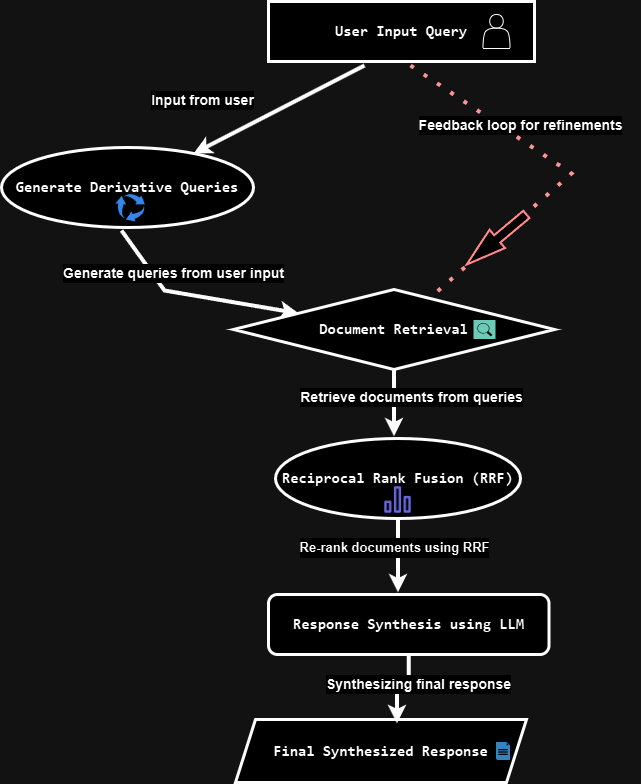

## Code Example for Fusion RAG

The following Python code demonstrates how Fusion RAG works by creating sample documents, loading them, generating queries, retrieving relevant documents, and synthesizing a response.



In [ ]:
!pip install pypdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from groq import Groq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Step 0: Set up the Groq client
client = Groq(api_key="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")

In [ ]:
# Step 1: Download and Read the PDF
pdf_url = "https://arxiv.org/pdf/1810.04805.pdf"  # Example: BERT paper
pdf_path = "BERT_paper.pdf"

In [ ]:
response = requests.get(pdf_url)
with open(pdf_path, 'wb') as pdf_file:
    pdf_file.write(response.content)

In [ ]:
reader = PdfReader(pdf_path)
text = ""
for page in reader.pages:
    text += page.extract_text()

In [ ]:
# Step 2: Preprocess Text into Chunks
chunk_size = 1000
chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
print(f"Number of chunks created: {len(chunks)}")

Number of chunks created: 65


In [ ]:
# Step 3: Generate Multiple Derivative Queries Using LLM
original_query = "What is Masked LM?"

In [ ]:
derivative_queries = []
try:
    query_response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a query generation assistant."},
            {"role": "user", "content": f"Generate multiple derivative queries related to: {original_query}"},
        ],
        model="llama3-8b-8192",
    )
    derivative_queries = query_response.choices[0].message.content.split('\n')
    print(f"Generated Derivative Queries: {derivative_queries}")
except Exception as e:
    print(f"Error during query generation: {e}")

Generated Derivative Queries: ['Here are several derivative queries related to "What is Masked LM?":', '', '1. What is the purpose of Masked LM in Natural Language Processing?', '2. How does Masked LM differ from other language model architectures?', '3. What are the benefits of using Masked LM in AI applications?', '4. Can you provide an example of how Masked LM is used in a real-world scenario?', '5. How does the masking process work in Masked LM?', '6. What are the limitations of Masked LM and how can they be addressed?', '7. How does Masked LM compare to other masked language models, such as Word Piece Encoding?', '8. What are some common applications of Masked LM in industries like healthcare, finance, and education?', '9. Can you explain the advantage of using a combination of Masked LM and other NLP techniques, such as TensorFlow in a speech recognition system?', '10. How does the training process for Masked LM differ from other language models?', '11. What is the role of attent

In [ ]:
# Step 4: Document Retrieval for Original and Derivative Queries
all_queries = [original_query] + derivative_queries
vectorizer = TfidfVectorizer()
query_embeddings = vectorizer.fit_transform(all_queries)
chunk_embeddings = vectorizer.transform(chunks)

In [ ]:
# Retrieve relevant documents for each query
retrieved_documents = []
for query_embedding in query_embeddings:
    similarities = cosine_similarity(query_embedding, chunk_embeddings).flatten()
    top_k_indices = similarities.argsort()[-3:][::-1]  # Get top 3 relevant chunks
    retrieved_documents.append([chunks[i] for i in top_k_indices])

In [ ]:
# Step 5: Apply Reciprocal Rank Fusion (RRF)
def reciprocal_rank_fusion(retrieved_documents):
    document_scores = {}

    for idx, docs in enumerate(retrieved_documents):
        for rank, doc in enumerate(docs):
            if doc not in document_scores:
                document_scores[doc] = 0
            # Calculate reciprocal rank score
            document_scores[doc] += 1 / (rank + 1)

    # Sort documents based on their RRF scores
    sorted_docs = sorted(document_scores.items(), key=lambda x: x[1], reverse=True)
    return [doc for doc, score in sorted_docs]

In [ ]:
# Get the fused and reranked documents using RRF
fused_documents = reciprocal_rank_fusion(retrieved_documents)

In [ ]:
# Step 6: Limit Fused Documents and Response Synthesis Using LLM
if fused_documents:
    # Limit to top N documents to avoid exceeding context length
    limited_context = "\n\n".join(fused_documents[:5])  # Adjust this number as needed (e.g., top 5)

    try:
        final_response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": f"Based on the following context:\n\n{limited_context}\n\nAnswer the query: {original_query}"},
            ],
            model="llama3-8b-8192",
        )
        print("\n--- Final Response ---\n")
        print(final_response.choices[0].message.content)
    except Exception as e:
        print(f"Error during final response generation: {e}")
else:
    print("No documents found. Unable to generate a response.")


--- Final Response ---

According to the text, Masked LM (MLM) is a procedure where some percentage of the input tokens are randomly masked and then predicted. This is done to train a deep bidirectional representation. The final hidden vectors corresponding to the mask tokens are fed into an output softmax over the vocabulary, as in a standard language model.


## Step-by-step Explanation of the Code

## 1. Set up the Groq Client
- Initializes the Groq API client using an **API key**.
- This client is used to send requests to Groq and get responses from the model.

## 2. Download and Read the PDF
- The PDF document is downloaded from the given **URL** (in this case, the BERT paper from arXiv).
- The document is saved locally as `BERT_paper.pdf` and its text is extracted using **PyPDF2** (`PdfReader`).

## 3. Preprocess Text into Chunks
- The entire text of the document is divided into smaller **chunks** of size 1000 characters for easier processing.
- This is done to avoid issues with large input context when using language models.
- The number of chunks created is printed for feedback.

## 4. Generate Multiple Derivative Queries Using LLM
- An initial query is defined (e.g., "How does Fusion RAG work?").
- The Groq model generates **derivative queries** related to the original query.
- The generated queries are then printed for review.

## 5. Document Retrieval for Original and Derivative Queries
- **TF-IDF Vectorization** is used to create embeddings for both the original query and its derivatives.
- The **cosine similarity** between query embeddings and chunk embeddings is calculated to retrieve the top 3 most relevant document chunks for each query.
  
## 6. Reciprocal Rank Fusion (RRF)
- The **Reciprocal Rank Fusion (RRF)** algorithm is applied to combine and re-rank the retrieved documents.
  - **RRF** assigns higher scores to documents that appear earlier in the rankings.
  - This allows combining results from multiple queries into a more effective ranked list of documents.

## 7. Limit Fused Documents and Synthesize Final Response Using LLM
- After applying RRF, the **top N documents** are selected to form the final context (limited to avoid exceeding model’s input size).
- The Groq model is used to generate the **final response** to the original query based on the selected context.
- If no relevant documents are found, an error message is printed.





## Applications of Fusion RAG



- **Customer Support**: Providing comprehensive answers to customer inquiries by integrating information from various knowledge bases and support documents.
  
- **Research Assistance**: Helping researchers gather and synthesize information from diverse academic sources, enhancing literature reviews and data analysis.

- **Content Generation**: Assisting content creators in generating well-rounded articles or reports by pulling in insights from multiple perspectives and data points.

- **Healthcare**: Supporting medical professionals with integrated information from clinical guidelines, research papers, and patient records for better decision-making.



## Advantages of Fusion RAG



- **Enhanced Accuracy**: By considering multiple perspectives through various queries, Fusion RAG improves the accuracy and comprehensiveness of responses.
  
- **Robustness**: The integration of different data sources ensures that the system remains effective even if some sources fail or provide limited information.

- **Contextual Relevance**: Dynamic adaptation to query context allows for more relevant results tailored to user needs.

## Limitations of Fusion RAG



- **Complexity**: Implementing multiple retrieval methods and managing diverse data sources can increase system complexity and require more sophisticated infrastructure.

- **Resource Intensive**: The need for extensive computational resources to handle multiple queries and data sources may lead to higher operational costs.

- **Data Quality Dependency**: The effectiveness of Fusion RAG is heavily reliant on the quality and relevance of the data sources used; poor-quality data can lead to inaccurate responses.

- **Latency Issues**: The integration of various retrieval methods may introduce latency in response times, especially if real-time processing is required.



## Conclusion



Fusion RAG represents a significant advancement in retrieval-augmented generation techniques. By combining various retrieval methods and dynamically adapting to context, it enhances response quality and provides users with comprehensive and accurate answers. As AI continues to evolve, methodologies like Fusion RAG will play a crucial role in delivering more effective and intelligent systems.



Having explored Fusion RAG, we now move on to Agentic RAG.